# Pandas vs. PyArrow file reading speed comparison

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import os
import sys
import matplotlib as mpl
mpl.rcParams['figure.dpi']=125

# Create CSV files of various sizes

In [3]:
for i in range(1,11): #10csv files with incresing rows, each contains 100 cols of data, starts from 5325 and mutilple with 5325
    a = np.random.normal(size=(int(5325*i), int(1e2)))
    df = pd.DataFrame(a, columns=["C" + str(i) for i in range(100)])
    fname = "test"+str(i)+".csv"
    df.to_csv(fname)
    print(f"Size of file with {5325*i} rows: {round(os.path.getsize(fname)/(1024*1024),3)} MB")

Size of file with 5325 rows: 9.993 MB
Size of file with 10650 rows: 19.989 MB
Size of file with 15975 rows: 29.992 MB
Size of file with 21300 rows: 39.99 MB
Size of file with 26625 rows: 49.991 MB
Size of file with 31950 rows: 59.986 MB
Size of file with 37275 rows: 69.988 MB
Size of file with 42600 rows: 79.99 MB
Size of file with 47925 rows: 89.988 MB
Size of file with 53250 rows: 99.99 MB


# Create Parquet (compressed) files from the same CSV files

In [4]:
#Create Parquet files from csv with zip compress, to reduce file size
for i in range(1,11):
    fname = "test"+str(i)+".csv"
    parquet_name = "test"+str(i)+"_parquet.zip"
    df = pd.read_csv(fname)
    df.to_parquet(parquet_name,compression="gzip")
    print(f"Created {parquet_name}")

Created test1_parquet.zip
Created test2_parquet.zip
Created test3_parquet.zip
Created test4_parquet.zip
Created test5_parquet.zip
Created test6_parquet.zip
Created test7_parquet.zip
Created test8_parquet.zip
Created test9_parquet.zip
Created test10_parquet.zip


# Reading speed of CSV (in Pandas) and Parquet files (with PyArrow)

In [5]:
#testing Reading speed of CSV and Parquet files with pyarrow
t_read_pd,t_read_arrow = [],[]
for i in range(1,11):
    fname = "test"+str(i)+".csv"
    parquet_name = "test"+str(i)+"_parquet.zip"
    t1 = time.time()
    df1 = pd.read_csv(fname) 
    t2 = time.time()
    delta_t = round((t2 - t1), 3)
    t_read_pd.append(delta_t) #store for csv
    t1 = time.time()
    df2 = pq.read_table(parquet_name) 
    t2 = time.time()
    delta_t = round((t2 - t1), 3)
    t_read_arrow.append(delta_t) #store for pyarrow
    print(f"Done for file # {i}")

Done for file # 1
Done for file # 2
Done for file # 3
Done for file # 4
Done for file # 5
Done for file # 6
Done for file # 7
Done for file # 8
Done for file # 9
Done for file # 10


In [6]:
t_read_pd = np.array(t_read_pd)
t_read_arrow = np.array(t_read_arrow)

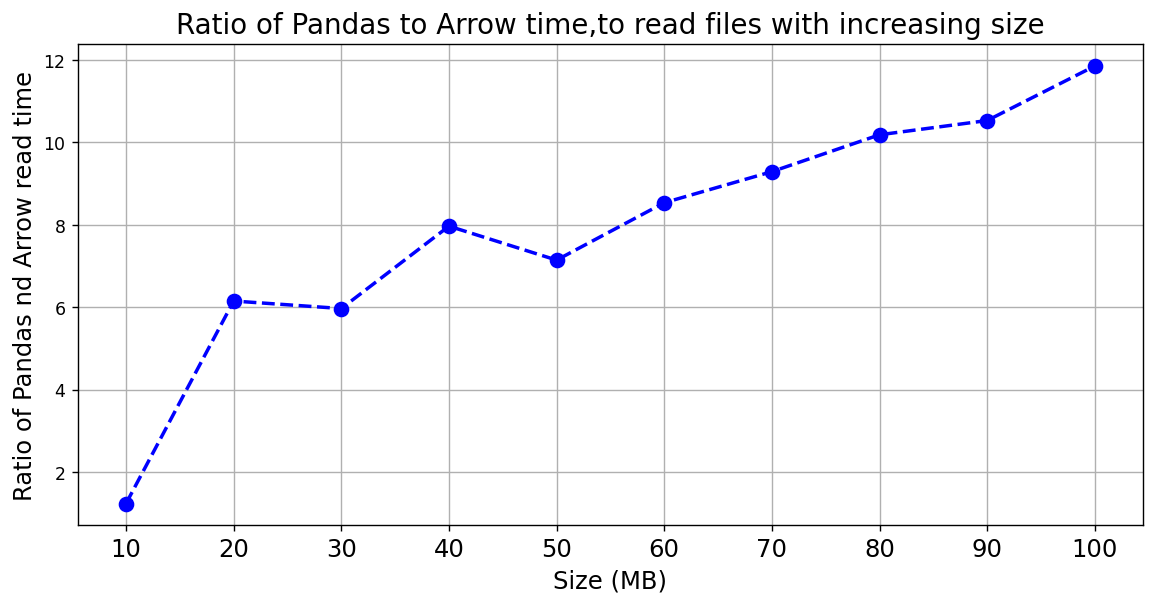

In [7]:
plt.figure(figsize=(11, 5))#Time taken by arrow to read parquet files
plt.plot(
    [10*i for i in range(1, 11)], t_read_pd/t_read_arrow, "bo--", linewidth=2, markersize=8
)
plt.grid(True)
plt.title(
    "Ratio of Pandas to arrow time,to read files with increasing size",
    fontsize=16,
)
plt.xticks([10*i for i in range(1, 11)],fontsize=14)
plt.xlabel("Size (MB)", fontsize=14)
plt.ylabel("Ratio of Pandas nd arrow read time", fontsize=14)
plt.show()#It shows size of file increases ratio of pandas to aroow decreases, which means arrow faster than pandas 

# What is the order of read time? Seconds, milliseconds?

In [8]:
#readtime
t1 = time.time()
df1 = pd.read_csv("test10.csv", usecols=["C1", "C99"])
t2 = time.time()
delta_t = round((t2 - t1), 3)
print(
    "Time taken to read 2 cols of 100 MB(53250rows)CSV file with Pandas:",
    delta_t,
    "seconds",
)

Time taken to read 2 cols of 100 MB(53250rows)CSV file with Pandas: 0.359 seconds


In [8]:
#reading speed of 100 MB CSV file in pd.read_csv() is 0.359 seconds at that time it changing every time

In [9]:
df1.head()

,C1,C99
0,-1.967512,0.679824
1,-0.601604,2.739391
2,1.324610,0.605263
3,-0.553981,1.352939
4,-0.859907,-1.083045


In [10]:
t1 = time.time()
df2 = pq.read_table("test10_parquet.zip", columns=["C1", "C99"])
t2 = time.time()
delta_t = round((t2 - t1), 3)
print(
    "Time taken to read 2 columns of the same 53250 rows zipped parquet files with PyArrow:",
    delta_t,
    "seconds",
)

Time taken to read 2 columns of the identical 53250 rows zipped parquet file with PyArrow: 0.016 seconds


In [12]:
#reading speed ofsame file in pq.read_table() is 0.016 seconds

In [13]:
# Convert from PyArrow table to dataframe
df3 = df2.to_pandas()
df3.head()

,C1,C99
0,-1.967512,0.679824
1,-0.601604,2.739391
2,1.324610,0.605263
3,-0.553981,1.352939
4,-0.859907,-1.083045


In [14]:
#df1 and df3 are the appro same

In [15]:
#small number of columns is much faster with Arrow

# Reading a small number of columns is much faster with Arrow

In [9]:
all_cols = ["C" + str(i) for i in range(100)]
t_pandas, t_arrow = [], [] #Time taken to read random cols from files its equal parquet files using pandas & arrow
for i in range(2, 100, 2):
    cols = list(np.random.choice(all_cols, size=i))
    t1 = time.time()
    df1 = pd.read_csv("test10.csv", usecols=cols)
    t2 = time.time()
    delta_t_pandas = round((t2 - t1), 3) #stores
    t_pandas.append(delta_t_pandas)
    t1 = time.time()
    df2 = pq.read_table("test10_parquet.zip", columns=cols)
    t2 = time.time()
    delta_t_arrow = round((t2 - t1), 3) #stored
    t_arrow.append(delta_t_arrow)
    print(f"Done for {i} columns")

Done for 2 columns
Done for 4 columns
Done for 6 columns
Done for 8 columns
Done for 10 columns
Done for 12 columns
Done for 14 columns
Done for 16 columns
Done for 18 columns
Done for 20 columns
Done for 22 columns
Done for 24 columns
Done for 26 columns
Done for 28 columns
Done for 30 columns
Done for 32 columns
Done for 34 columns
Done for 36 columns
Done for 38 columns
Done for 40 columns
Done for 42 columns
Done for 44 columns
Done for 46 columns
Done for 48 columns
Done for 50 columns
Done for 52 columns
Done for 54 columns
Done for 56 columns
Done for 58 columns
Done for 60 columns
Done for 62 columns
Done for 64 columns
Done for 66 columns
Done for 68 columns
Done for 70 columns
Done for 72 columns
Done for 74 columns
Done for 76 columns
Done for 78 columns
Done for 80 columns
Done for 82 columns
Done for 84 columns
Done for 86 columns
Done for 88 columns
Done for 90 columns
Done for 92 columns
Done for 94 columns
Done for 96 columns
Done for 98 columns


In [10]:
t_pandas = np.array(t_pandas)
t_arrow = np.array(t_arrow)

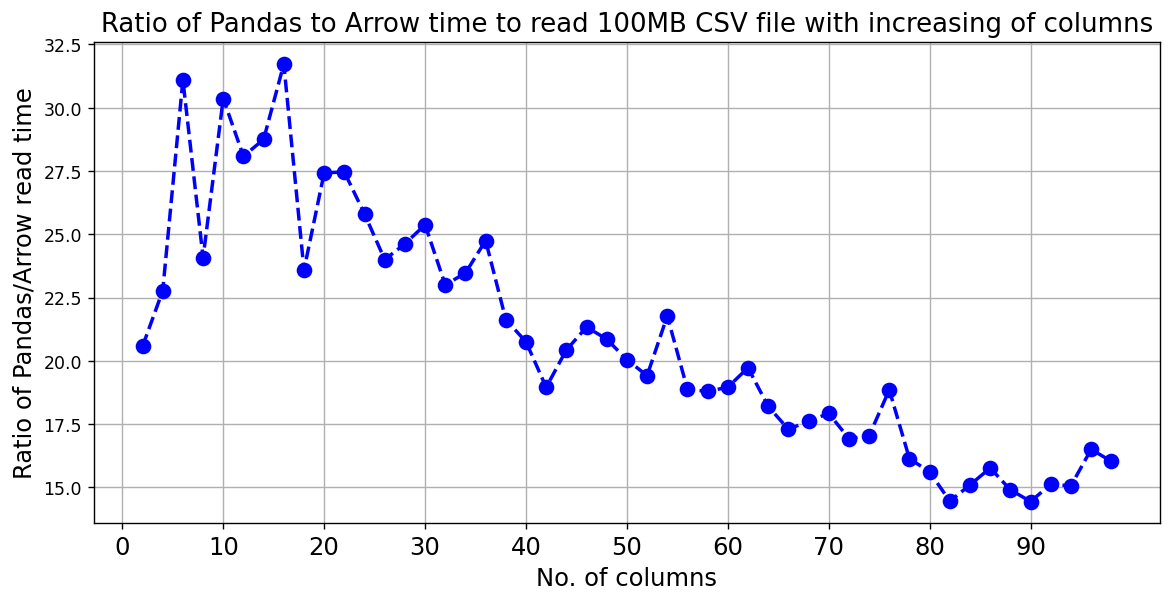

In [11]:
plt.figure(figsize=(11, 5)) #Time taken arrow & pandas to read files with increasing cols
plt.plot(
    [i for i in range(2, 100, 2)], t_pandas / t_arrow, "bo--", linewidth=2, markersize=8
)
plt.grid(True)
plt.title(
    "Ratio of Pandas to arrow time to read 100MB CSV file with increasing of cols",
    fontsize=15,
)
plt.xticks([i for i in range(0, 100, 10)],fontsize=14)
plt.xlabel("No. of columns", fontsize=14)
plt.ylabel("Ratio of pandas/arrow read time", fontsize=14)
plt.show()
# ratio of Pandas to pyarrow read time decreases of cols increases, which means pyarrow is better with large data

# PyArrow (Parquet) reading time varies with sparsity in the file

In [13]:
pct_nan = []#Generates csv files with random normal data, size varies, converts csv to zip
for i in range(11,21):
    a = np.random.normal(size=(int(5325*5), int(1e2)))
    cutoff = -2+0.4*(i-11)
    a = np.where(a < cutoff, np.nan, a)
    p_nan = round(100*np.count_nonzero(np.isnan(a))/a.size,2)
    pct_nan.append(p_nan)
    df = pd.DataFrame(a, columns=["C" + str(i) for i in range(100)])
    fname = "test"+str(i)+".csv"
    df.to_csv(fname)
    print(f"NaN-filled file written with {p_nan}%")

NaN-filled file written with 2.27%
NaN-filled file written with 5.46%
NaN-filled file written with 11.53%
NaN-filled file written with 21.19%
NaN-filled file written with 34.44%
NaN-filled file written with 49.97%
NaN-filled file written with 65.52%
NaN-filled file written with 78.82%
NaN-filled file written with 88.45%
NaN-filled file written with 94.54%


In [14]:
for i in range(11,21):#all files read csv nd then writes compress parquet files
    fname = "test"+str(i)+".csv"
    parquet_name = "test"+str(i)+"_parquet.zip"
    df = pd.read_csv(fname)
    df.to_parquet(parquet_name,compression="gzip")
    print(f"Created {parquet_name}")

Created test11_parquet.zip
Created test12_parquet.zip
Created test13_parquet.zip
Created test14_parquet.zip
Created test15_parquet.zip
Created test16_parquet.zip
Created test17_parquet.zip
Created test18_parquet.zip
Created test19_parquet.zip
Created test20_parquet.zip


In [15]:
t_read_nan = [] #Time taken to read parquet files with per of Nan values
m_read_nan = []

for i in range(11, 21):
    parquet_name = "test" + str(i) + "_parquet.zip"
    t1 = time.time()
    df2 = pq.read_table(parquet_name)
    t2 = time.time()
    delta_t = round(1000 * (t2 - t1), 3)
    t_read_nan.append(delta_t)
    m_read_nan.append(df2.to_pandas()) #Append the pandas dataframe
    print(f"Done for file # {i}")

t_read_nan = np.array(t_read_nan


Done for file # 11
Done for file # 12
Done for file # 13
Done for file # 14
Done for file # 15
Done for file # 16
Done for file # 17
Done for file # 18
Done for file # 19
Done for file # 20


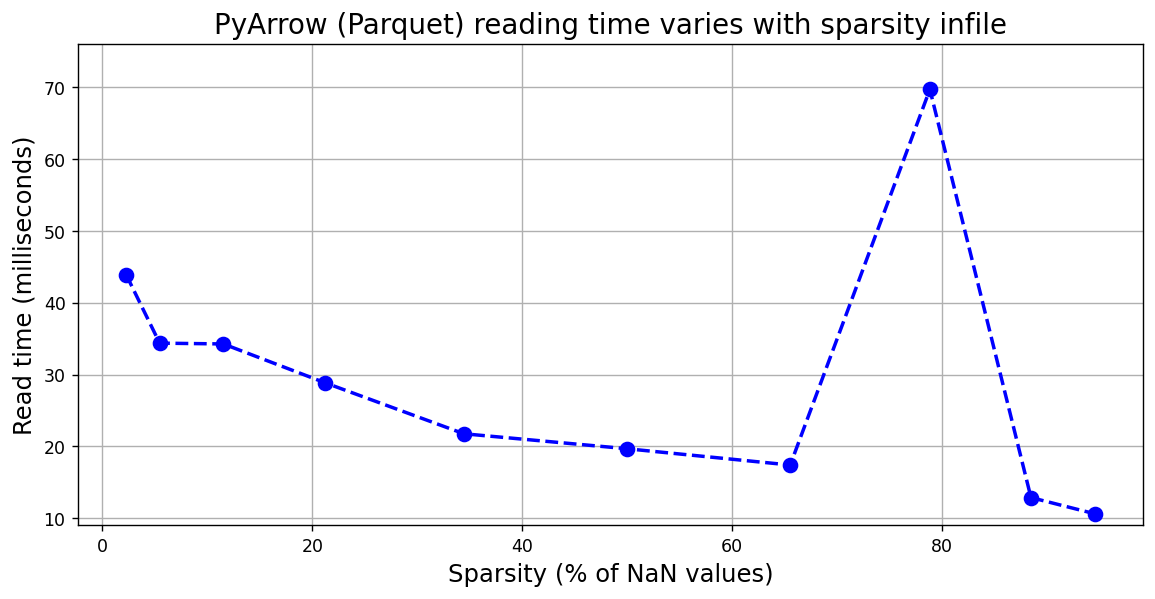

In [16]:
plt.figure(figsize=(11, 5))
plt.plot(pct_nan,t_read_nan, "bo--", linewidth=2, markersize=8)
plt.grid(True)
plt.title("Parquet reading time varies with sparsity infile",fontsize=16,)
#plt.xticks([10*i for i in range(1, 11)],fontsize=14)
plt.xlabel("Sparsity (% of NaN values)", fontsize=14)
plt.ylabel("Read time (milliseconds)", fontsize=14)
plt.ylim(int(t_read_nan.min()*0.9),int(t_read_nan.max()*1.1))
plt.show()
#As parquet increases reading time aslo increase, which means parquet is slower in 
#reading spare data compated to non spare data